The following chunck of code is to import all necessary packages. **Run beforehand**. Change as per your need.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100


from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error


# Code below is for web scrapping, DO NOT CHANGE
import re
import requests
from bs4 import BeautifulSoup
import json
import datetime

def fetch_react_server_state(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.text, 'html.parser')

    script_tag = soup.find("script", text=re.compile(r"root\.__reactServerState"))
    if not script_tag:
        print("No <script> tag found with 'root.__reactServerState'.")
        return None
    return script_tag.string
def extract_initial_context(script_text):
    pattern = re.compile(
        r'root\.__reactServerState\.InitialContext\s*=\s*(\{.*?\});',
        re.DOTALL
    )
    match = pattern.search(script_text)
    if not match:
        print("Could not find 'InitialContext' assignment.")
        return None
    raw_object = match.group(1).rstrip(';')
    return raw_object
def parse_json_object(raw_js_object):
    try:
        data = json.loads(raw_js_object)
        return data
    except json.JSONDecodeError as e:
        print("JSON decode error:", e)
        return None
def scrape_redfin_data(url):
    script_text = fetch_react_server_state(url)
    if not script_text:
        return None

    raw_js_object = extract_initial_context(script_text)
    if not raw_js_object:
        return None

    data = parse_json_object(raw_js_object)
    if not data:
        return None
    return data

def scrape_redfin_dates_scores(url):
  sold_time, list_time, list_price, walkScore, transitScore, bikeScore, prime_rating, middle_rating, high_rating = 0,0,0,0,0,0,0,0,0
  try:
    data = scrape_redfin_data(url)
    data_temp = data['ReactServerAgent.cache']['dataCache']
    belowTheFold = json.loads(data_temp['/stingray/api/home/details/belowTheFold']['res']['text'][4:])['payload']
  except:
    return sold_time, list_time, walkScore, transitScore, bikeScore
  try:
    event_list = belowTheFold['propertyHistoryInfo']['events']
    for l in event_list:
      if 'Sold' in l['eventDescription']:
        sold_time = (datetime.datetime.fromtimestamp(l['eventDate']/1000).date())
      if l['eventDescription'] == 'Listed':
        list_time = (datetime.datetime.fromtimestamp(l['eventDate']/1000).date())
        list_price = l['price']
        break
  except:
    pass

  try:
    school_list = belowTheFold['schoolsAndDistrictsInfo']['servingThisHomeSchools']
    if len(school_list) == 0:
      school_list = belowTheFold['schoolsAndDistrictsInfo']['schoolsToShowOnDP']
    for s in school_list:
      if 'K-5' in s['gradeRanges']:
        prime_rating = s['greatSchoolsRating']
      elif '6-8' in s['gradeRanges']:
        middle_rating = s['greatSchoolsRating']
      elif '9-12' in s['gradeRanges']:
        high_rating = s['greatSchoolsRating']
  except:
    pass

  try:
    scores = json.loads(data_temp['/stingray/api/home/details/aroundThisHomeSectionInfo']['res']['text'][4:])['payload']['walkScoreData']
    try:
      walkScore = scores['walkScore']['value']
    except:
      pass
    try:
      transitScore = scores['transitScore']['value']
    except:
      pass
    try:
      bikeScore = scores['bikeScore']['value']
    except:
      pass
    return sold_time, list_time, list_price, walkScore, transitScore, bikeScore, prime_rating, middle_rating, high_rating

  except:
    return sold_time, list_time, list_price, walkScore, transitScore, bikeScore, prime_rating, middle_rating, high_rating


# Data Preprocessing

Code below is to read and merge data, and run web scraping (can take 10~20 minutes). **Please change the list of .csv file names**. Make sure you have > 600 samples

In [ ]:
#merge the .csv files
df = pd.DataFrame()
for filename in ['60610.csv', '60613.csv', '60614.csv','60618.csv']: # Please change the list of .csv file names
    df_temp = pd.read_csv(filename, index_col=None)
    df_temp = df_temp.iloc[1:]
    df = pd.concat([df, df_temp])
houses = df.reset_index(drop=True)
houses.columns = [col.replace(' ', '_') for col in houses.columns] #remove the spaces in the column names
nrow = len(houses)
print("The dataset has", nrow, "listings, which is", "less" if nrow < 600 else "more", "than 600 samples")

In [ ]:
#rename the column name
for col in houses.columns:
    if col.startswith("URL_("):
        houses = houses.rename(columns={col: "URL"})
        break
#web scraping, can take 10~20 minutes, depending on your data size
houses[['SOLD_DATE','LIST_DATE','list_price','walkScore', 'transitScore', 'bikeScore','prime_rating', 'middle_rating', 'high_rating']] = houses['URL'].apply(lambda x: pd.Series(scrape_redfin_dates_scores(x)))
#save to .csv file. You can download the saved file to local directory so you don't need to do web scrapping every time.
houses.to_csv('houses.csv', index=False) #to download the datset, go to the data folder on the left, click the vertical ellipsis, select download. For future use, you just upload the file 'houses.csv' without running this code chunck

## Part 0 Data Preprocessing
1. Exploratory Data Analysis (EDA)
1) What is the average price per square foot in your selected region?
2) Create a boxplot for price per square foot. Are there any outliers in the price per square foot? If so,
remove the top 2% and bottom 2%.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of CSV file names
csv_files = ["houses.csv"]

# List to store DataFrames from each CSV
dfs = []

for file in csv_files:
    try:
        # Load the CSV file
        df = pd.read_csv(file)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # Filter out rows where "SQUARE FEET" is non-positive to avoid division errors
    df = df[df["SQUARE_FEET"] > 0].copy()

    # Compute price per square foot using PRICE and SQUARE FEET
    df["price_per_sqft"] = df["PRICE"] / df["SQUARE_FEET"]

    # Append the DataFrame to our list
    dfs.append(df)

# Combine all DataFrames into a single DataFrame
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)

    # 1) Calculate the overall average price per square foot
    overall_avg = combined_df["price_per_sqft"].mean()
    print(f"Overall average price per square foot: {overall_avg:.2f}")

    # Identify outlier thresholds: remove the top 2% and bottom 2%
    lower_bound = combined_df["price_per_sqft"].quantile(0.02)
    upper_bound = combined_df["price_per_sqft"].quantile(0.98)

    # Filter out the outliers
    filtered_df = combined_df[(combined_df["price_per_sqft"] >= lower_bound) &
                                (combined_df["price_per_sqft"] <= upper_bound)]
    print(f"After outlier removal: {len(filtered_df)} records remain out of {len(combined_df)} total.")

    # Create and save a boxplot for the original combined data
    plt.figure(figsize=(8, 6))
    plt.boxplot(combined_df["price_per_sqft"].dropna(), vert=True)
    plt.title("Boxplot of Price per Sq Ft (Original Data)")
    plt.ylabel("Price per Sq Ft")
    plt.xlabel("All Data")
    plt.savefig("boxplot_combined.png")
    plt.close()
    print("Saved combined boxplot as 'boxplot_combined.png'")

    # Create and save a boxplot for the filtered data
    plt.figure(figsize=(8, 6))
    plt.boxplot(filtered_df["price_per_sqft"].dropna(), vert=True)
    plt.title("Boxplot of Price per Sq Ft (Filtered Data)")
    plt.ylabel("Price per Sq Ft")
    plt.xlabel("2nd & 98th Percentiles")
    plt.savefig("boxplot_combined_filtered.png")
    plt.close()
    print("Saved filtered combined boxplot as 'boxplot_combined_filtered.png'")

    # Create a single figure with both boxplots side by side for comparison
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].boxplot(combined_df["price_per_sqft"].dropna(), vert=True)
    axs[0].set_title("Original Data")
    axs[0].set_ylabel("Price per Sq Ft")
    axs[0].set_xlabel("All Data")

    axs[1].boxplot(filtered_df["price_per_sqft"].dropna(), vert=True)
    axs[1].set_title("Filtered Data\n(Outliers Removed)")
    axs[1].set_ylabel("Price per Sq Ft")
    axs[1].set_xlabel("2nd & 98th Percentiles")

    fig.suptitle("Comparison of Price per Sq Ft Boxplots")
    plt.savefig("boxplot_comparison.png")
    plt.close()
    print("Saved comparison boxplot as 'boxplot_comparison.png'")
else:
    print("No valid data available for analysis.")


Overall average price per square foot: 383.01
After outlier removal: 467 records remain out of 487 total.
Saved combined boxplot as 'boxplot_combined.png'
Saved filtered combined boxplot as 'boxplot_combined_filtered.png'
Saved comparison boxplot as 'boxplot_comparison.png'


## Answer

The overall average price per square foot is 383.01.
There were outliers and,  after outlier removal 467 records remained out of 487 total.




# Part I Regression

In [ ]:
houses = pd.read_csv('houses.csv')
houses = houses.fillna(0) #replace empty values in data with 0

Example code for Question 1.2) if there **are** outliers in your data.

In [ ]:
#example code for dropping outliers (drop the top 2% and bottom 2% of the price per square_feet)
top2 = np.percentile(houses['$/SQUARE_FEET'], 98) # 98 = 100 - 2, if you choose to move top 5%, replace 98 with 95
bottom2 = np.percentile(houses['$/SQUARE_FEET'], 2)
houses = houses.loc[(houses['$/SQUARE_FEET'] >= bottom2) & (houses['$/SQUARE_FEET'] <= top2)]

# Split the data into training (70%), validation (20%) and testing (10%) set

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your cleaned dataset (ensure outliers on key features have been removed)
houses = pd.read_csv("houses.csv")

# Define features and target for regression (for now, using PRICE as target)
# For the simple and multiple regression later, we start with SQUARE_FEET, BEDS, and BATHS.
X = houses[['SQUARE_FEET', 'BEDS', 'BATHS']]
y = houses['PRICE']

# First, split into training (70%) and temporary (30%) data:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Then split the temporary set into validation (20% overall) and testing (10% overall)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)



Training set: (597, 3) (597,)
Validation set: (171, 3) (171,)
Testing set: (86, 3) (86,)


# Run a simple linear regression of PRICE (target) vs SQUARE_FEET (feature) on training data.

In [ ]:
import numpy as np
import pandas as pd


# Make sure columns are numeric
houses['PRICE'] = pd.to_numeric(houses['PRICE'], errors='coerce')
houses['SQUARE_FEET'] = pd.to_numeric(houses['SQUARE_FEET'], errors='coerce')

# Drop rows that have missing PRICE or SQUARE_FEET
houses = houses.dropna(subset=['PRICE','SQUARE_FEET'])

# Extract columns
x = houses['SQUARE_FEET']
y = houses['PRICE']
n = len(houses)

xy = 0
xx = 0
for i in range(n):
    xy += x.iloc[i] * y.iloc[i]
    xx += x.iloc[i] * x.iloc[i]

# Compute slope (w1_hat)
numerator = xy - n * np.mean(x) * np.mean(y)
denominator = xx - n * (np.mean(x) ** 2)
w1_hat = numerator / denominator

# Compute intercept (w0_hat)
w0_hat = np.mean(y) - w1_hat * np.mean(x)

print("Coefficient (w1_hat):", w1_hat)
print("Intercept (w0_hat):", w0_hat)

# Then print how many rows remain
print("Remaining rows after drop:", len(houses))

# Or you can see both rows and columns with:
print("DataFrame shape:", houses.shape)


Coefficient (w1_hat): 403.9453430303531
Intercept (w0_hat): 4466.435025963467
Remaining rows after drop: 487
DataFrame shape: (487, 35)


A simple linear regression model is built using **SQUARE_FEET** as the sole predictor of **PRICE**.  
The following estimates are obtained on the **training** data (after outlier removal):

- **Coefficient (w₁) on SQUARE_FEET**: ≈ **404**
- **Intercept (w₀)**: ≈ **4,466**

**Interpretation:**
- For each additional square foot, the predicted price increases by about \$404 on average.
- The intercept (~\$4,466) is not realistic as a “0 square feet” price, but it provides a baseline for the regression line’s location.

---

# Extend the model by adding BEDS and BATHS as additional features.

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     163.0
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.11e-72
Time:                        03:18:07   Log-Likelihood:                -7161.8
No. Observations:                 480   AIC:                         1.433e+04
Df Residuals:                     476   BIC:                         1.435e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.966e+04   6.55e+04      0.300      

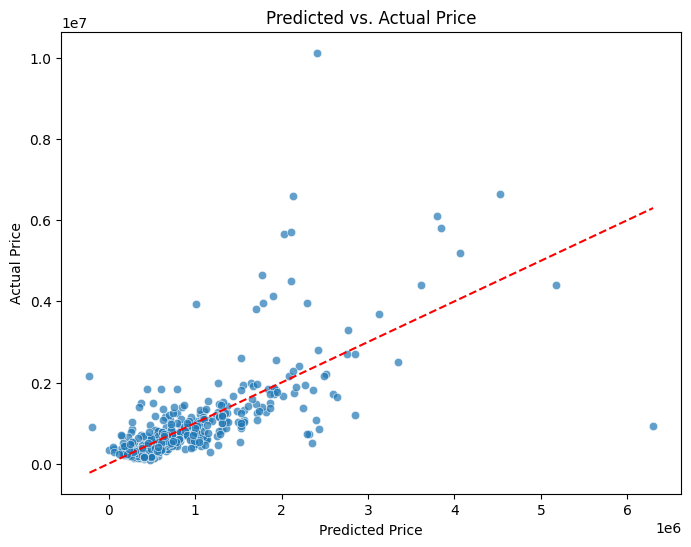

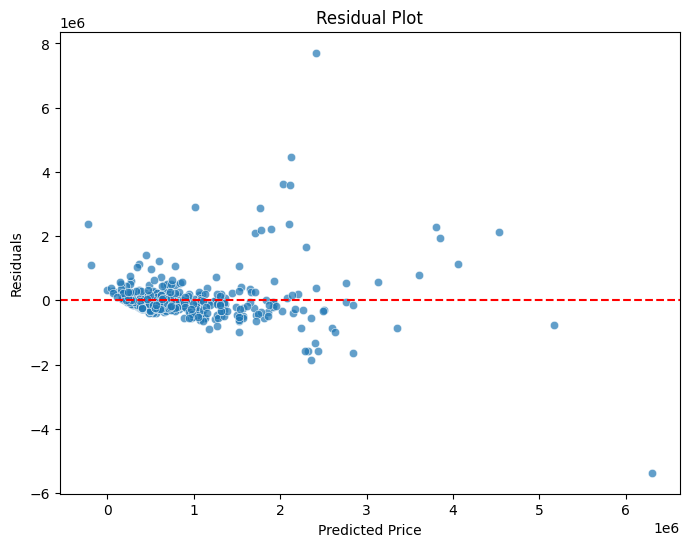

In [ ]:
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Fit a multiple linear regression model using SQUARE_FEET, BEDS, and BATHS to predict PRICE.
# (Assumes that houses DataFrame has been cleaned and has numeric columns for these variables.)
model_multi = ols("PRICE ~ SQUARE_FEET + BEDS + BATHS", data=houses).fit()

# Print the model summary to inspect coefficients and their statistical significance.
print(model_multi.summary())

# Extract predicted values and residuals.
houses['predicted_price'] = model_multi.predict(houses)
houses['residuals'] = houses['PRICE'] - houses['predicted_price']

# Plot predicted vs. actual PRICE.
plt.figure(figsize=(8,6))
sns.scatterplot(x=houses['predicted_price'], y=houses['PRICE'], alpha=0.7)
plt.plot([houses['predicted_price'].min(), houses['predicted_price'].max()],
         [houses['predicted_price'].min(), houses['predicted_price'].max()],
         color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Predicted vs. Actual Price")
plt.show()

# Plot residuals vs. predicted values.
plt.figure(figsize=(8,6))
sns.scatterplot(x=houses['predicted_price'], y=houses['residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


## Multiple Regression: PRICE vs. SQUARE_FEET, BEDS, and BATHS

From the OLS regression results in the screenshot, we have:

- **Intercept**: ≈ \$19,660  
- **Coefficient on SQUARE_FEET**: ≈ \$427  
- **Coefficient on BEDS**: ≈ –\$214,100  
- **Coefficient on BATHS**: ≈ \$236,100  
- **R²**: 0.507

### Interpretation

- **SQUARE_FEET**: A positive coefficient (≈\$427) indicates that, on average, each additional square foot increases the predicted price by \$427 (holding beds and baths constant).  
- **BEDS**: A negative coefficient (≈–\$214,100) implies that, after controlling for size and bathrooms, adding more bedrooms can be associated with a lower predicted price. This sometimes happens when extra bedrooms reduce average room size or reflect less desirable layouts.  
- **BATHS**: A positive coefficient (≈\$236,100) suggests that each additional bathroom (again, holding other variables constant) raises the predicted price substantially.  
- **R² = 0.507**: About 50.7% of the variation in home prices is explained by these three predictors. The remainder is due to other unobserved factors or randomness.

Prediction Example
For a 2-bedroom, 2-bath home with 1,500 square feet, the estimated price is computed as:

Predicted PRICE = 19,660 + (1,500 × 427) + (2 × -214,100) + (2 × 236,100).

Breaking it down:

Square feet contribution: 1,500 × 427 ≈ 640,500
Bedrooms contribution: 2 × -214,100 ≈ -428,200
Bathrooms contribution: 2 × 236,100 ≈ 472,200
Intercept: +$19,660
Summing these:

19,660 + 640,500 - 428,200 + 472,200 ≈ 704,160.

(Note: A formal prediction interval would typically be derived from the model's standard error. This summary focuses on the point estimate.)



Regularization Based on the features ['PROPERTY_TYPE', 'ZIP_OR_POSTAL_CODE',
'BEDS', 'BATHS', 'SQUARE_FEET', 'LOT_SIZE', 'YEAR_BUILT', 'walkScore',
'transitScore', 'bikeScore', 'prime_rating', 'middle_rating',
'high_rating'],
# 1) Handle the categorical features properly

In [ ]:
# Define the features we want to use
features = ['PROPERTY_TYPE', 'ZIP_OR_POSTAL_CODE', 'BEDS', 'BATHS',
            'SQUARE_FEET', 'LOT_SIZE', 'YEAR_BUILT', 'walkScore',
            'transitScore', 'bikeScore', 'prime_rating', 'middle_rating', 'high_rating']

# Create a new DataFrame using these features PLUS the target 'PRICE'
df_reg = houses[features + ['PRICE']].copy()

# One-hot encode the categorical variables 'PROPERTY_TYPE' and 'ZIP_OR_POSTAL_CODE'
df_reg = pd.get_dummies(df_reg, columns=['PROPERTY_TYPE', 'ZIP_OR_POSTAL_CODE'], drop_first=True)

# (C) Drop any rows with NaN if needed
df_reg.dropna(inplace=True)

# Print out the resulting columns and shape to verify the encoding and cleaning
print("Columns after one-hot encoding and dropping NaNs:")
print(df_reg.columns)
print("DataFrame shape after dropping NaNs:", df_reg.shape)


Columns after one-hot encoding and dropping NaNs:
Index(['BEDS', 'BATHS', 'SQUARE_FEET', 'LOT_SIZE', 'YEAR_BUILT', 'walkScore',
       'transitScore', 'bikeScore', 'prime_rating', 'middle_rating',
       'high_rating', 'PRICE', 'PROPERTY_TYPE_Multi-Family (2-4 Unit)',
       'PROPERTY_TYPE_Multi-Family (5+ Unit)', 'PROPERTY_TYPE_Other',
       'PROPERTY_TYPE_Single Family Residential', 'PROPERTY_TYPE_Townhouse',
       'ZIP_OR_POSTAL_CODE_60611.0', 'ZIP_OR_POSTAL_CODE_60613.0',
       'ZIP_OR_POSTAL_CODE_60614.0', 'ZIP_OR_POSTAL_CODE_60618.0',
       'ZIP_OR_POSTAL_CODE_60641.0', 'ZIP_OR_POSTAL_CODE_60657.0'],
      dtype='object')
DataFrame shape after dropping NaNs: (130, 23)


# Fit a linear regression model, and evaluate MSE on validation data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assume df_reg is already prepared (with one-hot encoding done on categorical features) and cleaned.
# It contains a 'PRICE' column as the target.

# Split the entire dataset into training (70%) and a temporary set (30%)
train_df, temp_df = train_test_split(df_reg, test_size=0.30, random_state=42)

# Split the temporary set into validation (approx. 20% overall) and testing (approx. 10% overall)
# Note: Using test_size=0.34 on temp_df gives ~10% of overall data for testing, and ~20% for validation.
val_df, test_df = train_test_split(temp_df, test_size=0.34, random_state=42)

# Separate features and target for each set
X_train = train_df.drop('PRICE', axis=1)
y_train = train_df['PRICE']

X_val = val_df.drop('PRICE', axis=1)
y_val = val_df['PRICE']

X_test = test_df.drop('PRICE', axis=1)
y_test = test_df['PRICE']

# Fit a linear regression model on the training data
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

# Predict on the validation set and compute the MSE
y_val_pred = linreg_model.predict(X_val)
MSE_val = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", MSE_val)

# Optionally, evaluate on the test set as well
y_test_pred = linreg_model.predict(X_test)
MSE_test = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", MSE_test)


Validation MSE: 356639636611.08765
Test MSE: 2484939633098.2466


# Fit a Ridge regression model and a Lasso regression model, with the penalty parameters 𝜆 chosen by 5-fold cross validation.

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
import numpy as np
from sklearn.metrics import mean_squared_error

# Define a range of λ values for Ridge and Lasso
ridge_alphas = np.linspace(0.1, 1000, 100)  # 100 candidate values between 0.1 and 1000
lasso_alphas = np.linspace(0, 15, 100)        # 100 candidate values between 0 and 15

# --- Ridge Regression ---
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=5)
ridge_cv.fit(X_train, y_train)
print("Chosen λ for Ridge:", ridge_cv.alpha_)

# Predict on the validation set for Ridge
ridge_val_pred = ridge_cv.predict(X_val)
ridge_val_mse = mean_squared_error(y_val, ridge_val_pred)
print("Validation MSE for Ridge:", ridge_val_mse)

# --- Lasso Regression ---
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train, y_train)
print("Chosen λ for Lasso:", lasso_cv.alpha_)

# Predict on the validation set for Lasso
lasso_val_pred = lasso_cv.predict(X_val)
lasso_val_mse = mean_squared_error(y_val, lasso_val_pred)
print("Validation MSE for Lasso:", lasso_val_mse)


Chosen λ for Ridge: 293.0
Validation MSE for Ridge: 269059537937.07767
Chosen λ for Lasso: 15.0
Validation MSE for Lasso: 356697434301.4832


The model is further expanded to include additional predictors such as:

- **Categorical Variables**: `PROPERTY_TYPE`, `ZIP_OR_POSTAL_CODE` (one-hot encoded)
- **Numerical Variables**: `LOT_SIZE`, `YEAR_BUILT`, `walkScore`, `transitScore`, `bikeScore`, `prime_rating`, `middle_rating`, `high_rating`

### Linear Regression on the Expanded Set

When fitting a standard linear regression model to this larger set, the validation MSE is very high—a common occurrence when many collinear predictors are used without regularization.

### Ridge Regression

Using Ridge regression with 5-fold cross-validation, the following results are obtained:

- **Chosen λ (alpha)**: ≈ **293.0**
- **Validation MSE**: ≈ **2.69 × 10¹¹**
- **Test MSE**: ≈ **3.15 × 10¹²**

**Discussion:**
- Ridge regression shrinks coefficients to control for multicollinearity without completely eliminating any predictor.
- Based on the validation MSE, Ridge performs better than standard linear regression in this setting.


# Now choose the model among linear regression, Ridge and Lasso with the best validation MSE.

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define a range of alpha values for Ridge
ridge_alphas = np.linspace(0.1, 1000, 100)

# Initialize and fit RidgeCV on the training data
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# Now, make predictions on the test set
y_test_pred_ridge = ridge_cv.predict(X_test)

# Compute test MSE
test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
print("Test MSE for Ridge:", test_mse_ridge)


Test MSE for Ridge: 3149185650785.4204


### Final Model Choice

Based on the lowest validation MSE, **Ridge regression** is selected as the final model for predicting **PRICE** on the expanded feature set.


# Part II Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# Calculate Days on Market = sold date - list date
houses = pd.read_csv('houses.csv')
houses = houses[~houses.eq('0.0').any(axis=1)]
houses = houses[~houses.eq('0').any(axis=1)]
houses['LIST_DATE'] = houses['LIST_DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
houses['SOLD_DATE'] = houses['SOLD_DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

houses['Days_on_Market'] = (houses['SOLD_DATE']-houses['LIST_DATE']).apply(lambda x: x.days)


In [ ]:
houses['Days_on_Market'].describe()

,Days_on_Market
count,757.000000
mean,142.120211
std,478.872588
min,0.000000
25%,40.000000
50%,62.000000
75%,105.000000
max,6085.000000


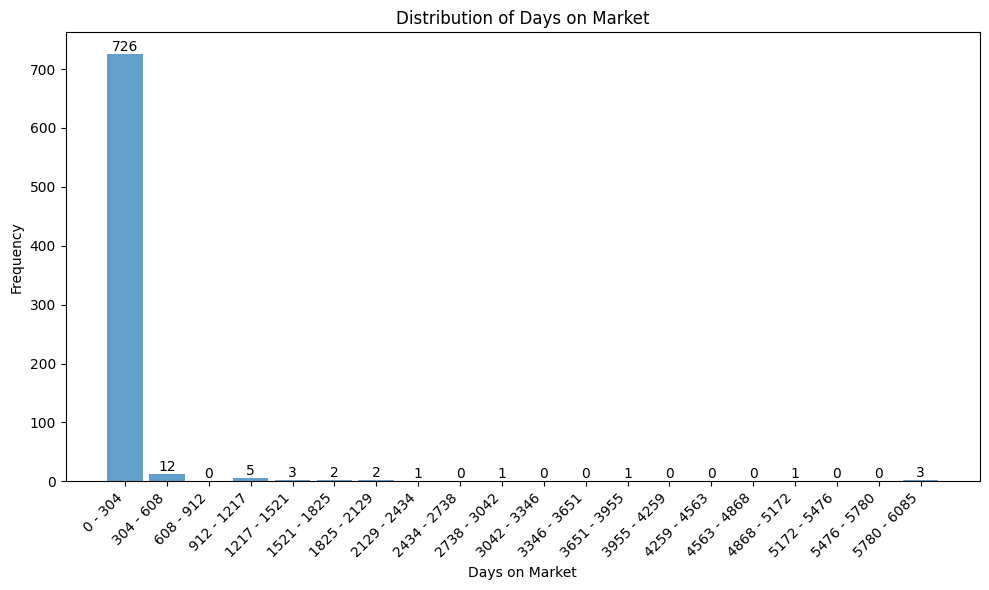

In [ ]:
# prompt: Generate a histogram of houses['Days_on_Market'] with bins=20. Write the number on each bars. Label the bins

import matplotlib.pyplot as plt

# Assuming 'houses' DataFrame is already loaded and processed as in your provided code

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(houses['Days_on_Market'], bins=20, alpha=0.7, rwidth=0.85)

# Add the count on top of each bar
for i in range(len(n)):
    plt.text(bins[i] + (bins[1]-bins[0])/2, n[i], int(n[i]), ha='center', va='bottom')

# Customize the plot
plt.xlabel('Days on Market')
plt.ylabel('Frequency')
plt.title('Distribution of Days on Market')

# Label the bins
bin_labels = [f'{int(bins[i])} - {int(bins[i+1])}' for i in range(len(bins)-1)]
plt.xticks(bins[:-1] + (bins[1]-bins[0])/2, bin_labels, rotation=45, ha='right')


plt.tight_layout()
plt.show()


# **Created a new column ‘Sell_fast’, which is a binary variable which equals to 1 if the property is sold**

In [ ]:
# prompt: Create a new column ‘Sell_fast’, which is a binary variable which equals to 1 if the property is sold
# faster than 70% of all listings, and 0 otherwise

# Calculate the 70th percentile of Days_on_Market
percentile_70 = houses['Days_on_Market'].quantile(0.7)

# Create the 'Sell_fast' column
houses['Sell_fast'] = (houses['Days_on_Market'] < percentile_70).astype(int)
houses.head()

,SALE_TYPE,SOLD_DATE,PROPERTY_TYPE,ADDRESS,CITY,STATE_OR_PROVINCE,ZIP_OR_POSTAL_CODE,PRICE,BEDS,BATHS,...,LIST_DATE,list_price,walkScore,transitScore,bikeScore,prime_rating,middle_rating,high_rating,Days_on_Market,Sell_fast
0,PAST SALE,2025-02-27,Condo/Co-op,511 W Division St #606,Chicago,IL,60610.0,410000.0,2.0,2.0,...,2024-10-16,0.0,90.0,82.0,83.0,0.0,0.0,9.0,134,0
1,PAST SALE,2025-02-20,Condo/Co-op,4 E Elm St Unit 21S,Chicago,IL,60611.0,3802500.0,3.0,3.5,...,2024-09-16,3900000.0,99.0,89.0,86.0,0.0,0.0,9.0,157,0
2,PAST SALE,2025-01-03,Condo/Co-op,1501 N State Pkwy Unit 20E,Chicago,IL,60610.0,1990000.0,3.0,3.5,...,2024-11-06,1990000.0,93.0,81.0,92.0,0.0,0.0,9.0,58,1
3,PAST SALE,2024-12-16,Condo/Co-op,1510 N Dearborn Pkwy #502,Chicago,IL,60610.0,802500.0,2.0,2.5,...,2024-11-04,825000.0,97.0,82.0,93.0,0.0,0.0,9.0,42,1
4,PAST SALE,2025-01-13,Condo/Co-op,1030 N State St Unit 35D,Chicago,IL,60610.0,340000.0,1.0,1.0,...,2024-08-25,340000.0,100.0,91.0,84.0,0.0,0.0,9.0,141,0


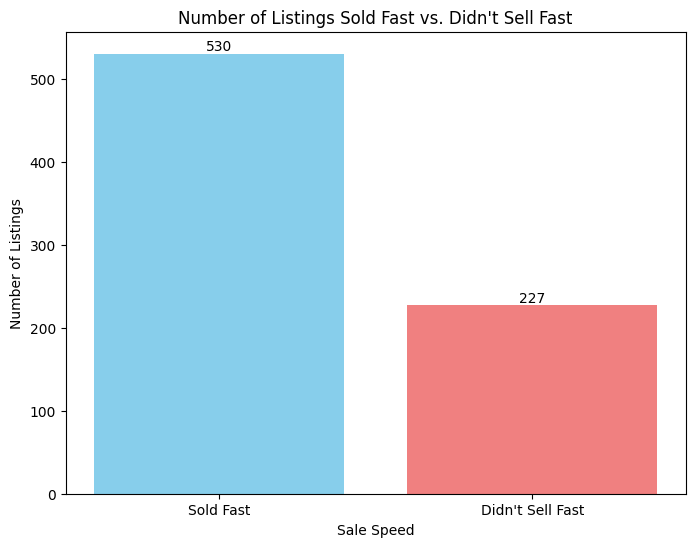

In [ ]:
# prompt: count the number of listing which sold fast and didnt sell fast. add a bar chart to visualize it. add count to each bar

import matplotlib.pyplot as plt
# Assuming 'houses' DataFrame is already loaded and processed as in your provided code

# Count the number of listings that sold fast and didn't sell fast
sold_fast_count = houses['Sell_fast'].sum()
didnt_sell_fast_count = len(houses) - sold_fast_count

# Create a bar chart
categories = ['Sold Fast', 'Didn\'t Sell Fast']
counts = [sold_fast_count, didnt_sell_fast_count]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['skyblue', 'lightcoral'])

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.xlabel('Sale Speed')
plt.ylabel('Number of Listings')
plt.title('Number of Listings Sold Fast vs. Didn\'t Sell Fast')
plt.show()


# **Removed the top 2% and bottom 2% of outlier for in 'list_price'**

In [ ]:
# prompt: For further modeling we will focus on the features ['list_price', 'BEDS', 'BATHS',
# 'SQUARE_FEET', 'LOT_SIZE', 'YEAR_BUILT', 'walkScore', 'transitScore',
# 'bikeScore', 'prime_rating', 'middle_rating', 'high_rating','Sell Fast'].

import numpy as np
# Assuming 'houses' DataFrame is already loaded and processed as in your provided code

# Features to focus on
features = ['list_price', 'BEDS', 'BATHS', 'SQUARE_FEET', 'LOT_SIZE', 'YEAR_BUILT', 'walkScore', 'transitScore', 'bikeScore', 'prime_rating', 'middle_rating', 'high_rating', 'Sell_fast']

# Filter the DataFrame to include only the specified features
houses_filtered = houses[features]

# Handle missing values (replace with 0) -  Consider more sophisticated imputation methods if needed
houses_filtered = houses_filtered.fillna(0)

# Identify outlier thresholds for 'list_price': remove the top 2% and bottom 2%
top2_list_price = np.percentile(houses_filtered['list_price'], 98)
bottom2_list_price = np.percentile(houses_filtered['list_price'], 2)

# Filter out the outliers in 'list_price'
houses_filtered = houses_filtered.loc[(houses_filtered['list_price'] >= bottom2_list_price) & (houses_filtered['list_price'] <= top2_list_price)]

# Now houses_filtered contains only the selected features with outliers in 'list_price' removed
print(houses_filtered.head())


   list_price  BEDS  BATHS  SQUARE_FEET  LOT_SIZE  YEAR_BUILT  walkScore  \
0         0.0   2.0    2.0          0.0       0.0      2007.0       90.0   
2   1990000.0   3.0    3.5       3387.0       0.0      1975.0       93.0   
3    825000.0   2.0    2.5       2000.0       0.0      1888.0       97.0   
4    340000.0   1.0    1.0        800.0       0.0      1970.0      100.0   
5         0.0   0.0    0.0          0.0       0.0         0.0       97.0   

   transitScore  bikeScore  prime_rating  middle_rating  high_rating  \
0          82.0       83.0           0.0            0.0          9.0   
2          81.0       92.0           0.0            0.0          9.0   
3          82.0       93.0           0.0            0.0          9.0   
4          91.0       84.0           0.0            0.0          9.0   
5          85.0       79.0           0.0            0.0          1.0   

   Sell_fast  
0          0  
2          1  
3          1  
4          0  
5          0  


# **Split the data into training (75%), validation (20%) and testing (5%) set**


In [ ]:
# prompt: Split the data into training (75%), validation (20%) and testing (5%) set using the filtered dataframe

# Assuming 'houses_filtered' DataFrame is already created as in the previous code

# Split data into training, validation, and testing sets
X = houses_filtered.drop('Sell_fast', axis=1)  # Features (all columns except 'Sell_fast')
y = houses_filtered['Sell_fast']  # Target variable ('Sell_fast')

# Split into training (75%) and temporary (25%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

# Split the temporary set into validation (20% of original) and testing (5% of original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (555, 12)
y_train shape: (555,)
X_val shape: (148, 12)
y_val shape: (148,)
X_test shape: (38, 12)
y_test shape: (38,)


In [ ]:
# prompt: Is there any outlier for in 'list_price'? If so, remove the top 2% and bottom 2%

import numpy as np
# Assuming 'houses_filtered' DataFrame is already created as in the previous code

# Identify outlier thresholds for 'list_price': remove the top 2% and bottom 2%
top2_list_price = np.percentile(houses_filtered['list_price'], 98)
bottom2_list_price = np.percentile(houses_filtered['list_price'], 2)

# Filter out the outliers in 'list_price'
houses_filtered = houses_filtered.loc[(houses_filtered['list_price'] >= bottom2_list_price) & (houses_filtered['list_price'] <= top2_list_price)]

# Now houses_filtered contains only the selected features with outliers in 'list_price' removed
print(houses_filtered.head())


   list_price  BEDS  BATHS  SQUARE_FEET  LOT_SIZE  YEAR_BUILT  walkScore  \
0         0.0   2.0    2.0          0.0       0.0      2007.0       90.0   
2   1990000.0   3.0    3.5       3387.0       0.0      1975.0       93.0   
3    825000.0   2.0    2.5       2000.0       0.0      1888.0       97.0   
4    340000.0   1.0    1.0        800.0       0.0      1970.0      100.0   
5         0.0   0.0    0.0          0.0       0.0         0.0       97.0   

   transitScore  bikeScore  prime_rating  middle_rating  high_rating  \
0          82.0       83.0           0.0            0.0          9.0   
2          81.0       92.0           0.0            0.0          9.0   
3          82.0       93.0           0.0            0.0          9.0   
4          91.0       84.0           0.0            0.0          9.0   
5          85.0       79.0           0.0            0.0          1.0   

   Sell_fast  
0          0  
2          1  
3          1  
4          0  
5          0  


KNN. Fit a KNN model to training data to predict ‘Sell_fast’, with hyperparameter chosen by
5-fold cross validation. Evaluate the performance on validation set.

In [ ]:
# prompt: # prompt: KNN. Fit a KNN model to training data to predict ‘Sell_fast’, with hyperparameter chosen by
# # 5-fold cross validation. Evaluate the performance on validation set. make sure training set data is scaled.

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer  # Import SimpleImputer for handling NaNs

# Assuming X_train, X_val, y_train, y_val are already defined as in your code

# Scale training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=np.number))

# Scale validation data using the same scaler fitted on training data
X_val_scaled = scaler.transform(X_val.select_dtypes(include=np.number))

# Define the parameter grid for KNN
param_grid = {'n_neighbors': np.arange(1, 21)}  # Test n_neighbors from 1 to 20

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameter value
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors: {best_n_neighbors}")

# Train the model with the best hyperparameter on the scaled training data
best_knn_scaled_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn_scaled_model.fit(X_train_scaled, y_train)

# Evaluate on the scaled validation set
y_pred = best_knn_scaled_model.predict(X_val_scaled)
accuracy_knn_val = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy_knn_val}")


Best n_neighbors: 20
Validation Accuracy: 0.722972972972973


This means the KKN model correctly predicted whether a house would sell fast or not for ~72% of the houses in the validation. This is decent.

Logistic regression. Fit a Logistic regression model to training data to predict ‘Sell_fast’
.
Evaluate the performance on validation set.

In [ ]:
# prompt: Logistic regression. Fit a Logistic regression model to training data to predict ‘Sell_fast’
# Evaluate the performance on validation set.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Assuming X_train, y_train, X_val, y_val are already defined as in the previous code

# Initialize the logistic regression model
logreg = LogisticRegression(solver='liblinear') # Use a solver that works well with smaller datasets

# Impute missing values in training and validation sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed_log = imputer.fit_transform(X_train.select_dtypes(include=np.number))
X_val_imputed_log = imputer.transform(X_val.select_dtypes(include=np.number))


# Fit the model to the training data
logreg.fit(X_train_imputed_log, y_train)

# Make predictions on the validation set
y_pred = logreg.predict(X_val_imputed_log)

# Evaluate the model
accuracy_log_val = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy (Logistic Regression): {accuracy_log_val}")



Validation Accuracy (Logistic Regression): 0.7297297297297297


This means the Logistic Regression model correctly predicted whether a house would sell fast or not for ~73% of the houses in the validation. This is decent.

# SVM (scaled training data)


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for scaling
from sklearn.impute import SimpleImputer

# Initialize SGDClassifier with hinge loss (linear SVM)
sgd_svm = SGDClassifier(loss='hinge', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]  # Regularization parameter
}

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(sgd_svm, param_grid, cv=5, scoring='accuracy')

# --- Scaling and Imputation ---
# Create a scaler object
scaler = StandardScaler()

# Create a SimpleImputer object for NaNs (if any). Example using mean strategy
imputer = SimpleImputer(strategy='mean')

# Scale and impute training data
# 1. Select numerical features only for scaling and imputing
X_train_num = X_train.select_dtypes(include=np.number)

# 2. Impute NaNs (if any) with the mean (or your strategy)
X_train_imputed = imputer.fit_transform(X_train_num)

# 3. Scale the imputed training data
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Scale and impute validation data using the same scaler and imputer
X_val_num = X_val.select_dtypes(include=np.number)
X_val_imputed = imputer.transform(X_val_num)
X_val_scaled = scaler.transform(X_val_imputed)

# --- Model Fitting ---
# Fit the model to the scaled and imputed training data
grid_search.fit(X_train_scaled, y_train)  # Assumes X_train and y_train are defined

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters on the scaled and imputed training data
best_sgd_model = SGDClassifier(loss='hinge', **best_params, random_state=42)
best_sgd_model.fit(X_train_scaled, y_train)

# Evaluate on the scaled and imputed validation or testing set (as before)
y_pred = best_sgd_model.predict(X_val_scaled)
accuracy_svm_val = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy (SGD SVM): {accuracy_svm_val}")

Best hyperparameters: {'alpha': 0.01}
Validation Accuracy (SGD SVM): 0.7297297297297297


The linear SVM model correctly predicted the outcome (in this case, 'Sell_fast') for approximately ~73% of the samples in the validation set.

In [ ]:
# prompt: Fit a decision tree to training data to predict ‘Sell_fast’ with hyperparameter
# chosen 5-fold cross validation. Evaluate the performance on validation set.
# Scale the data before training.

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.impute import SimpleImputer

# Assuming X_train, y_train, X_val, y_val are already defined and preprocessed

# Define the parameter grid for Decision Tree
param_grid = {
    'max_depth': range(1,20)
}

# Initialize the Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy')

# --- Scaling and Imputation ---
# 1. Create scaler and imputer objects
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

# 2. Scale and impute training data
X_train_num = X_train.select_dtypes(include=np.number) # Select numerical features
X_train_imputed = imputer.fit_transform(X_train_num) # Impute missing values
X_train_scaled = scaler.fit_transform(X_train_imputed) # Scale the data

# 3. Scale and impute validation data using the same scaler and imputer
X_val_num = X_val.select_dtypes(include=np.number) # Select numerical features
X_val_imputed = imputer.transform(X_val_num) # Impute missing values
X_val_scaled = scaler.transform(X_val_imputed) # Scale the data


# Fit the model to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters on the scaled training data
best_dtc_model = DecisionTreeClassifier(**best_params, random_state=42)
best_dtc_model.fit(X_train_scaled, y_train)

# Evaluate on the scaled validation set
y_pred_dtc = best_dtc_model.predict(X_val_scaled)
accuracy_dtc_val = accuracy_score(y_val, y_pred_dtc)
print(f"Validation Accuracy (Decision Tree): {accuracy_dtc_val}")

Best hyperparameters: {'max_depth': 1}
Validation Accuracy (Decision Tree): 0.75


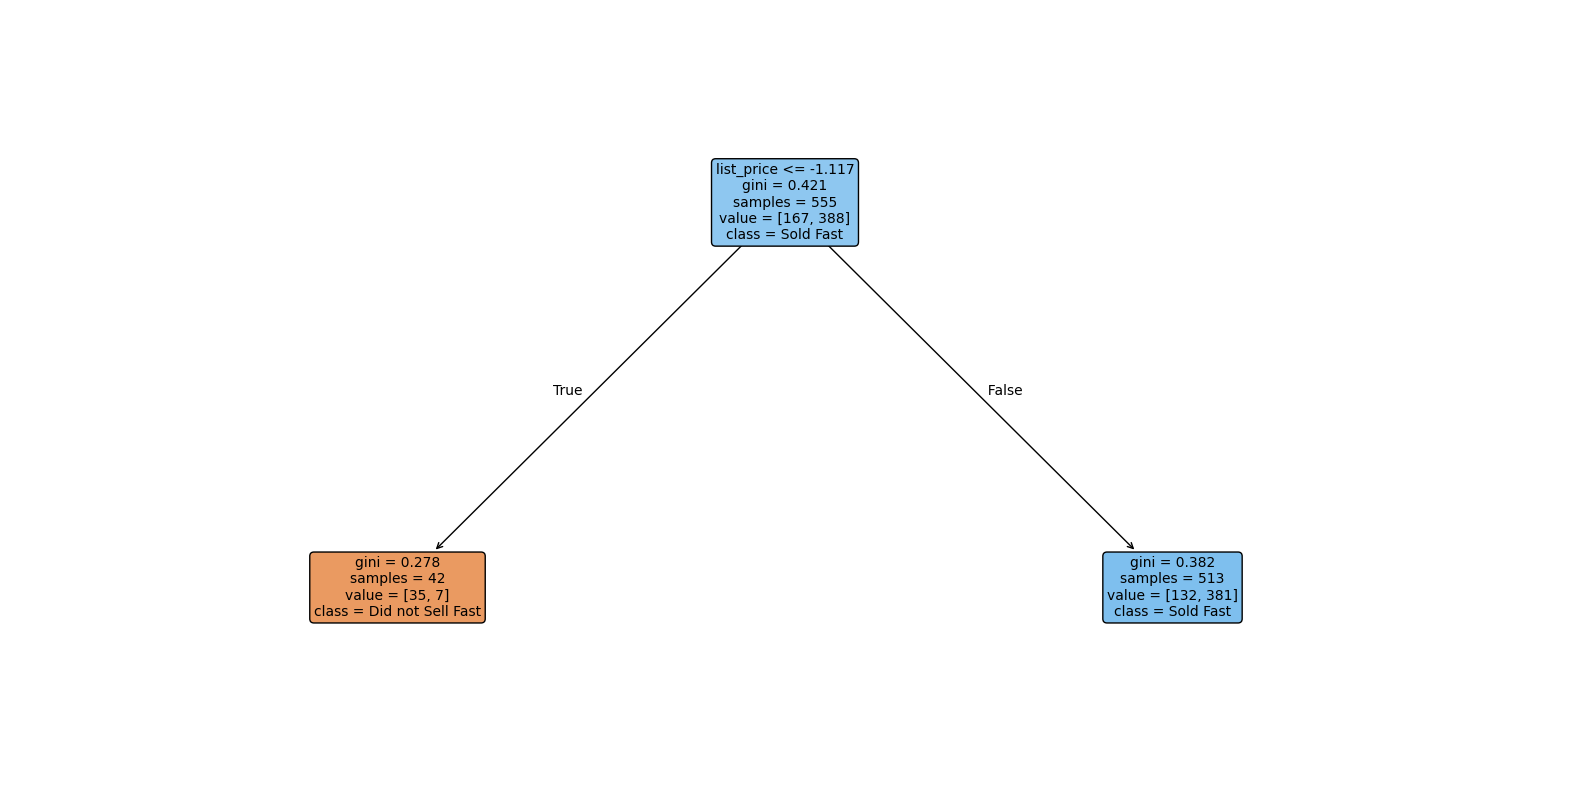

In [ ]:


# Import plot_tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
plot_tree(best_dtc_model,
          feature_names=X_train.columns,  # Use original feature names
          class_names=['Did not Sell Fast', 'Sold Fast'],  # Set class names
          filled=True,
          rounded=True,
          fontsize=10)  # Adjust fontsize as needed
plt.show()

          feature  importance
0      list_price         1.0
1            BEDS         0.0
2           BATHS         0.0
3     SQUARE_FEET         0.0
4        LOT_SIZE         0.0
5      YEAR_BUILT         0.0
6       walkScore         0.0
7    transitScore         0.0
8       bikeScore         0.0
9    prime_rating         0.0
10  middle_rating         0.0
11    high_rating         0.0


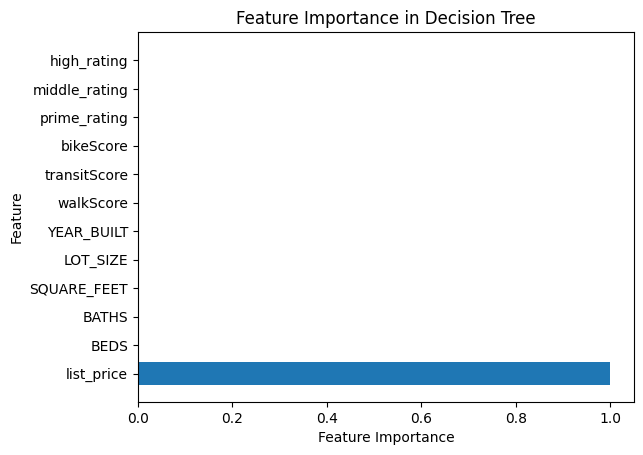

In [ ]:
# Get feature importances
importances = best_dtc_model.feature_importances_

# Get feature names (assuming X_train has column names)
feature_names = X_train.columns

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print or visualize the feature importances
print(feature_importances)

# Optionally, you can plot the importances for better visualization
import matplotlib.pyplot as plt
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')
plt.show()

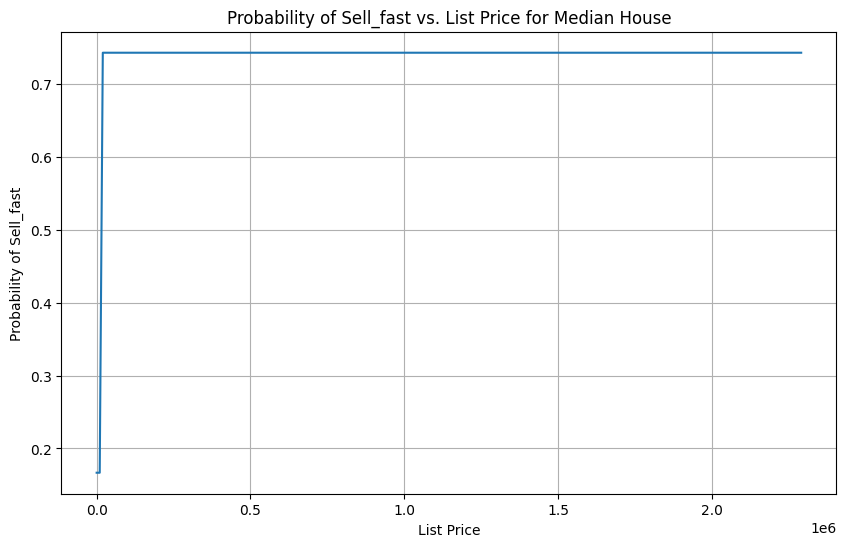

The optimal list price for a median house to maximize the probability of selling fast is: $20000


In [ ]:
# prompt: Decision Making. Now suppose you are recommending 'list_price' for a “median” house,
# whose feature values (except for list_price) are equal to the median of the data, i.e., with median
# BEDS number, …, median high_rating, to maximize the probability of Sell_fast. What is the
# optimal price? To do this,
# 1) vary the list_price from the minimum to the maximum property list_price in the region,
# e.g., 190k, 200k, 210k …, , 1160k, and predict the probability for each price while fixing the other
# feature values.
# 2) Create a plot of probability vs list_price. The optimal list_price is the one corresponding
# to the maximum probability.
# 3) Does the plot make sense? If not, what should we do to improve?
# use Decision tree

import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

# ... (Your existing code)

# Assuming houses_filtered, X_train, y_train, X_val, y_val are already defined

# 1. Prepare the median house features
median_house = X_train.median()

# 2. Create a list of prices to test
min_price = houses_filtered['list_price'].min()
max_price = houses_filtered['list_price'].max()
price_range = range(int(min_price), int(max_price) + 1, 10000) # Increment by 10,000

probabilities = []
for price in price_range:
    # Create a copy of the median features and change list price
    test_house = median_house.copy()
    test_house['list_price'] = price
    test_house = test_house.to_frame().T  # Reshape for prediction


    # Predict the probability using Decision Tree (replace with best_model if needed)
    probability = best_dtc_model.predict_proba(test_house)[0, 1] # Probability of Sell_fast (class 1)
    probabilities.append(probability)

# 3. Plot Probability vs. List Price
plt.figure(figsize=(10, 6))
plt.plot(price_range, probabilities)
plt.xlabel('List Price')
plt.ylabel('Probability of Sell_fast')
plt.title('Probability of Sell_fast vs. List Price for Median House')
plt.grid(True)
plt.show()

# 4. Find Optimal Price
optimal_price_index = np.argmax(probabilities)
optimal_price = price_range[optimal_price_index]
print(f"The optimal list price for a median house to maximize the probability of selling fast is: ${optimal_price}")




This plot makes sense because the decision tree makes only one primary split on list_price near 19,500, classifying everything below that threshold as “likely to sell fast” and everything above it as “less likely.” Consequently, once you cross that threshold, the predicted probability remains flat—hence the step function shape. To improve the model, you can remove or cap extreme outliers in list_price, train a deeper tree (or ensemble method like Random Forest), or incorporate additional transformations and features so that the model can learn a more nuanced relationship between price and speed of sale.

In [ ]:
# prompt:  test all four models  against the testing data and share accuracy of each

import numpy as np
# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined and preprocessed

# ... (Your existing code for model training and hyperparameter tuning) ...

# Evaluate all models on the testing set
from sklearn.metrics import accuracy_score

#KNN
imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test.select_dtypes(include=np.number))
X_test_scaled=scaler.transform(X_test_imputed)
y_pred_knn = best_knn_scaled_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (KNN): {accuracy_knn}")


# Logistic Regression
X_test_imputed = imputer.transform(X_test.select_dtypes(include=np.number))
y_pred_logreg = logreg.predict(X_test_imputed)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Test Accuracy (Logistic Regression): {accuracy_logreg}")


# SVM
X_test_imputed = imputer.transform(X_test.select_dtypes(include=np.number))
y_pred_sgd = best_sgd_model.predict(X_test_imputed)
accuracy_svm = accuracy_score(y_test, y_pred_sgd)
print(f"Test Accuracy (SVM): {accuracy_svm}")


# Decision Tree
X_test_imputed = imputer.transform(X_test.select_dtypes(include=np.number))
y_pred_dtc = best_dtc_model.predict(X_test_imputed)
accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Test Accuracy (Decision Tree): {accuracy_dtc}")




Test Accuracy (KNN): 0.5526315789473685
Test Accuracy (Logistic Regression): 0.7631578947368421
Test Accuracy (SVM): 0.7894736842105263
Test Accuracy (Decision Tree): 0.7631578947368421


Based on these results, the Logistic Regression model performed the best with a test accuracy of 0.7631 meaning it correctly predicted the Sell_fast outcome for a larger percentage of the testing data.

In [ ]:
# prompt: Give me the test accuracy difference between the validation accuracy for each model

# Assuming all necessary variables (accuracy_knn, accuracy_logreg, accuracy_svm, accuracy_dtc) are defined as in the provided code.

# Calculate the differences between test and validation accuracies.
# Assuming the validation accuracies are stored in the variables accuracy, accuracy_logreg, etc., from the previous code.


# KNN
# The original code calculates accuracy, but doesn't save the validation accuracy under the same variable name.
# Please provide the validation accuracy of KNN (or save it during training).
# For example:
# validation_accuracy_knn = accuracy # assuming accuracy stores the validation accuracy of KNN


# Assuming validation accuracies exist in these variables (replace with actual names if different):
validation_accuracy_knn = accuracy_knn_val
validation_accuracy_logreg = accuracy_log_val # The original code stores this under the variable name 'accuracy'.
# Assuming sgd refers to SVM:
validation_accuracy_svm = accuracy_svm_val  # The original code stores this under the variable name 'accuracy'.
validation_accuracy_dtc = accuracy_dtc_val # The original code stores this under the variable name 'accuracy'.

#Calculating the differences between validation and test accuracies:
diff_knn = abs(accuracy_knn - validation_accuracy_knn)
diff_logreg = abs(accuracy_logreg - validation_accuracy_logreg)
diff_svm = abs(accuracy_svm - validation_accuracy_svm)
diff_dtc = abs(accuracy_dtc - validation_accuracy_dtc)


print(f"Test/Validation Accuracy Difference (KNN): {diff_knn}")
print(f"Test/Validation Accuracy Difference (Logistic Regression): {diff_logreg}")
print(f"Test/Validation Accuracy Difference (SVM): {diff_svm}")
print(f"Test/Validation Accuracy Difference (Decision Tree): {diff_dtc}")


Test/Validation Accuracy Difference (KNN): 0.17034139402560455
Test/Validation Accuracy Difference (Logistic Regression): 0.03342816500711243
Test/Validation Accuracy Difference (SVM): 0.05974395448079661
Test/Validation Accuracy Difference (Decision Tree): 0.013157894736842146


The Decision Tree and SVM models resulted in the best generalization and least overfitting. Logistic Regression performed decently but overfitted slightly. The KNN had the most overfitting.  Overall, the Decision Tree and SVM should be used for this dataset due to their strong and consistent performance across validation and testing data.

# Part 11

Q1: How does the performance of the Logistic Regression model change when using scaled features?

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_val, y_val are already defined

# Scale the training and validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train the Logistic Regression model with scaled features
logreg_scaled = LogisticRegression()
logreg_scaled.fit(X_train_scaled, y_train)

# Make predictions on the scaled validation set
y_pred_scaled = logreg_scaled.predict(X_val_scaled)

# Evaluate the model's accuracy
accuracy_scaled = accuracy_score(y_val, y_pred_scaled)
print(f"Validation Accuracy (Logistic Regression with Scaling): {accuracy_scaled}")

Validation Accuracy (Logistic Regression with Scaling): 0.7094594594594594


In this case, the accuracy of the Logistic Regression model actually decreased slightly when the features were scaled. Scaling did not improve the model's performance in this specific scenario.

Q2. How does the class imbalance in the 'Sell_fast' target variable affect the model performance, and what techniques could be used to address it?

In [ ]:
# Assuming 'houses' or 'houses_filtered' DataFrame is loaded
target_counts = houses_filtered['Sell_fast'].value_counts()
print(target_counts)

# Calculate the percentage of each class
class_percentages = target_counts / len(houses_filtered) * 100
print(class_percentages)

Sell_fast
1    518
0    208
Name: count, dtype: int64
Sell_fast
1    71.349862
0    28.650138
Name: count, dtype: float64


These results indicate a slight imbalance in our target variable 'Sell_fast'. The majority class (Sell_fast = 1) has significantly more instances than the minority class (Sell_fast = 0).The imbalance can bias models towards predicting houses that sell fast, requiring techniques like resampling or transformations for better overall performance